# Data inspection in BigQuery - posts dataset

The data set used is a pubblic collection of 1.7 billion reddit comments and posts loaded on BigQuery in this [link](https://console.cloud.google.com/bigquery?p=fh-bigquery%2F&project=reddit-254019&folder&organizationId)

# Posts statistic

What we need is to find the subreddits with a constant popularity during the years.

There are thousands of criteria, the one I decided to follow (although not the most accurate) is to analyze the author, the number of posts published and the score.

Apart from the analysis of comments I decided to make an analysis for posts because the original post (title and corpus of it) should contain more key words that better identify the subreddit, precious information for my study.

Before reach the conclusion of what subreddits I selected for my study, here below I've summarize the queries and the steps followed that guided me to my conclusions.

As my data is in BigQuery, Colab is a perfect instrument to explore it.
First of all we need the authentication

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


and create the enviroment of my project.

In [3]:
%env GCLOUD_PROJECT=reddit-254019

env: GCLOUD_PROJECT=reddit-254019


Before starting my analysis I what to do some study about the lenght of  `titles` and `self` text.

In [4]:
%%bigquery --project reddit-254019
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.2018_*`
  WHERE
    selftext != '[deleted]'
    AND selftext != '[removed]'
    AND selftext != '[ Removed by reddit in response to a copyright notice. ]'
    AND selftext != 'NaN'
    AND selftext != ''),
  q2 AS (
  SELECT
    subreddit,
    MAX(LENGTH(title)) AS max_char_title,
    MIN(LENGTH(title)) AS min_char_title,
    MAX(LENGTH(selftext)) AS max_char_selftext,
    MIN(LENGTH(selftext)) AS min_char_selftext,
    ROUND(AVG(LENGTH(title)),2) AS avg_length_title,
    ROUND(AVG(LENGTH(selftext)),2) AS avg_length_selftext
  FROM
    q1
  GROUP BY
    1 )
SELECT
  subreddit,
  max_char_title,
  min_char_title,
  max_char_selftext,
  min_char_selftext,
  avg_length_title,
  avg_length_selftext
FROM
  q2
ORDER BY
  max_char_title DESC
  --min_char_title ASC
  --max_char_selftext DESC
  --min_char_selftext ASC
  --avg_length_title DESC
  --avg_length_title ASC
  --avg_length_selftext DESC
  --avg_length_selftext ASC

,subreddit,max_char_title,min_char_title,max_char_selftext,min_char_selftext,avg_length_title,avg_length_selftext
0,NFL4klivestreamHD,731,11,1164,120,74.27,289.38
1,AAAAAAAAAAAAAAAAA,600,1,40000,1,69.28,3152.61
2,u_RoyalPedro1,600,62,19900,77,420.67,7386.33
3,FalconsChiefsLive,595,150,1106,400,255.67,820.33
4,upaduckisgay,544,2,24834,2,45.33,1817.36
...,...,...,...,...,...,...,...
541832,u_northernkustoms,1,1,538,538,1.00,538.00
541833,u_LegendaryYH,1,1,75,51,1.00,63.00
541834,hhhhhhhhhhhhh,1,1,1,1,1.00,1.00
541835,u_InterplanetaryOak,1,1,30,30,1.00,30.00


Here a summary of the result changing the ```ORDER BY```

```
max_char_title = 731
min_char_title = 1
max_char_selftext = 256813
min_char_selftext = 1
max avg_length_title = 420.67
min avg_length_title = 1,00
max avg_length_selftext = 52010.5
min avg_length_selftext = 1,00
```


I start exploring only one year (2018) filtering the data by:

*   subreddit
*   author
*   count of title
*   count of selftext
*   average of number of comments per post
*   posts per author
*   score
*   year
*   month

This data must be analyzed considering some important point:

*   ```selftext``` can contain empty and null data
*   ```selftext```can be deleted and removed
*   ```num_comments```is an important information, the average can give an idea of the post most commented (and indirectually most popular)
*   ```posts_per_authors``` is an information that gives the number of post published per author

This last this last calculated field is the one I decided to use for filter the query ( ```posts_per_authors``` > 100) because gives us popularity information (number of unique authors that wirte a post) along with number of posts.

From the previous analysis, I've also decided to take the posts with the length of `title` and `selftext` respectively in mayor than 40 and mayor than 100

In [6]:
%%bigquery --project reddit-254019
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.2018_*`
  WHERE
    LENGTH(title) > 40
    AND LENGTH(selftext) > 100
    AND selftext != '[deleted]'
    AND selftext != '[removed]'
    AND selftext != '[ Removed by reddit in response to a copyright notice. ]'
    AND selftext != 'NaN'
    AND selftext != ''),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles,
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_authors,
    ROUND(AVG(score), 2) AS avg_score,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    7,
    8
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_authors,
  avg_score,
  year,
  month
FROM
  q2
WHERE
  --num_uniq_authors > 100
  avg_comments_in_post > 100
ORDER BY
  number_titles DESC


,uniq_subreddit,num_uniq_authors,number_titles,avg_comments_in_post,posts_per_authors,avg_score,year,month
0,nba,2311,4818,199.44,2.08,322.29,2018,5
1,nba,2123,4560,110.20,2.15,244.52,2018,3
2,nba,2229,4523,103.52,2.03,219.49,2018,1
3,nba,2123,4399,113.37,2.07,306.03,2018,11
4,nba,2110,4193,116.65,1.99,235.87,2018,2
...,...,...,...,...,...,...,...,...
2851,UFC229Live2018,1,1,1821.00,1.00,0.00,2018,10
2852,onstream24,1,1,477.00,1.00,15.00,2018,10
2853,HeroUnlocker,1,1,106.00,1.00,23.00,2018,2
2854,freedonuts,1,1,148.00,1.00,17.00,2018,9


Let's see with Data Studio the visualization of our data.

As for comments ds, also in posts can be usefull analyze `number_comments` and `num_uniq_authors` separately

In [3]:
from google.colab import files
uploaded = files.upload()

Saving posts_numbComments_unicAuthors.png to posts_numbComments_unicAuthors.png


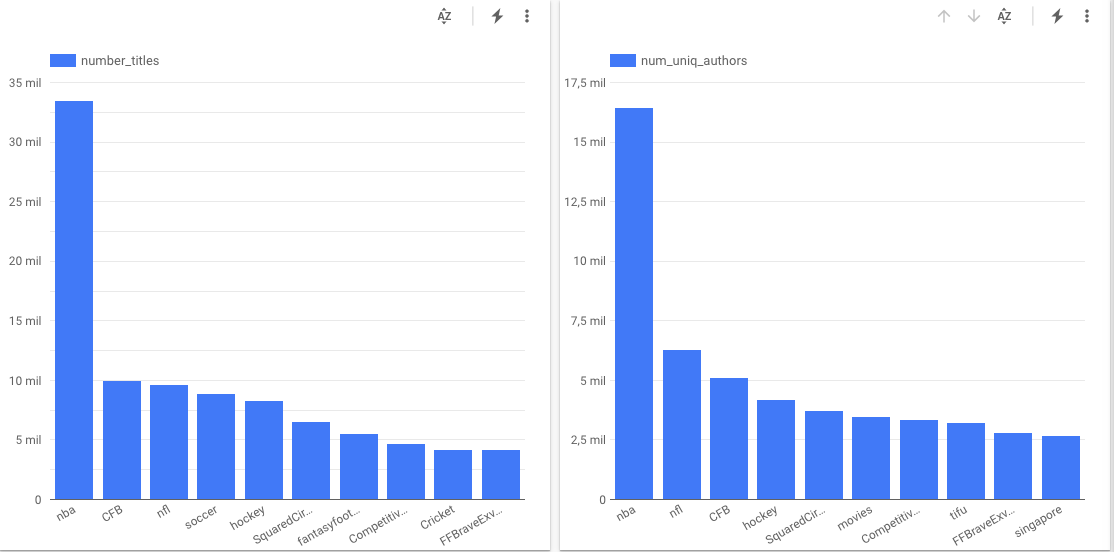

In [4]:
from IPython.display import Image
Image('posts_numbComments_unicAuthors.png', width = 1000)

There is a correlation between number of post published and number of unique authors.

Let's analyze also the avg of the score.

In [5]:
uploaded = files.upload()

Saving posts_numbComments_avgScore.png to posts_numbComments_avgScore.png


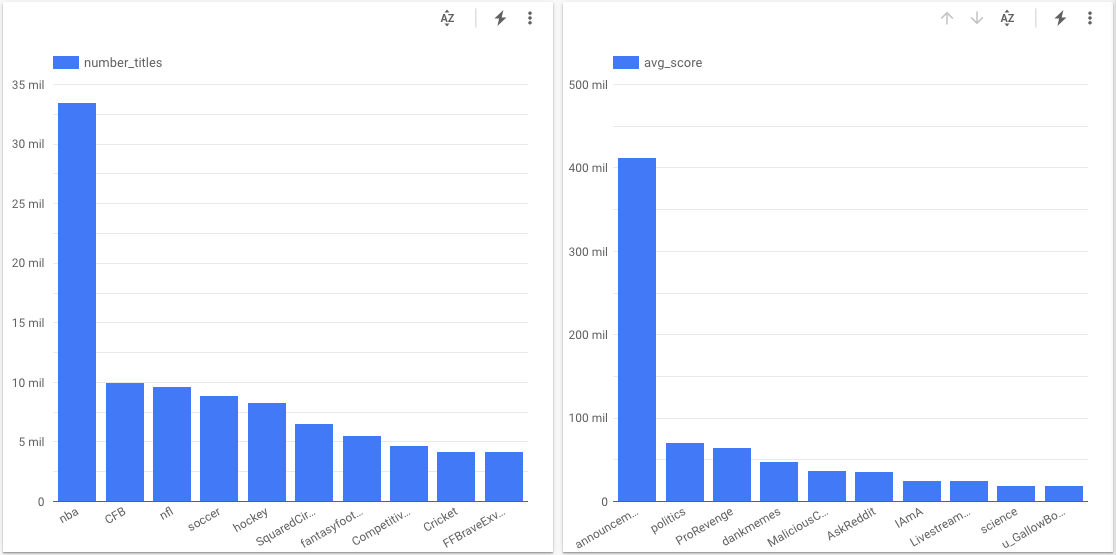

In [6]:
Image('posts_numbComments_avgScore.png', width = 1000)

Even if neader in this ds the data has been normalized, we can see a correlation between number of posts and average of score.

The problem we still have for ```score```is the not known information of how is has been calculated. 

## Top subreddits per year - posts table

What I would need is a function that, once the data has been normalized, is capable to suggest me the subreddit most populars in order of number of comments, number of unique authors that write on it and the score assigned.

This is a idea that I'll develop in the future, with more time, what I'll do for this analysis is, running the query below in each year, extract:

*   the top n subreddits with more posts published on it
*   the top n subreddit with more unique authors that writes on them
*   __exclude the score param__ for the simple reason that I need more time to analyze the formula that compose the data showed (should be a formula composed with upvotes and downvoltes but is not clear how has been calculated as the two params are not indicated in the dataset)

Finally, with this data, I'll study each subreddit selecting:

*   those with a costant popularity during the years 
*   those that cover a wider category threshold
For the last point I'll use the follow public classification on GitHub: [subreddit-Directory-Skeleton](https://github.com/MetASnoo/Subreddit-Directory-Skeleton/blob/master/subreddits.txt)

### Top posts in all years

The query will run all `reddit_posts` talble from 2005 to 2019. I should exclude 2005 because there are no subreddit a part of `reddit.com`but, for convenience I'll keep it.
